# Imports

In [195]:
import numpy as np
np.set_printoptions(threshold=np.nan,suppress=True)
import pandas as pd
import warnings
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
warnings.filterwarnings('ignore')

from datetime import datetime

from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

from sklearn.ensemble import RandomForestClassifier
from sklearn import metrics
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.cluster import KMeans, AgglomerativeClustering

from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

from sklearn.model_selection import GridSearchCV

import time

# I. Data Preparation Process

## Read csv

In [196]:
data = pd.read_csv('dataset_datascientist_case.csv', sep=',')
data.shape

(3379778, 20)

## Make a sample

The initial datasets is very heavy (3 millions rows). Let's work on a reduced sample.

In [197]:
n_sample = 10000
df = data.sample(n_sample)
df.head(5)

,driver_id,offer_id,trip_id,trip_date,published_date,signup_date,fixed_signup_country,is_main_trip,unit_seat_price_eur,seat_offered_count,seat_left_count,confirmed_seat_count,trip_distance_km,from_lat,from_lon,to_lat,to_lon,is_comfort,is_auto_accept_mode,publication_site_id
2745152,"59,352,609","179,089,446","978,037,950",2015-06-21 14:35:00,2015-06-18 00:00:00,2015-03-14 00:00:00,FR,False,38.28,2,0,0,460,47.6582,-2.76085,44.8378,-0.579180,False,False,"5,000"
3146932,"2,750,539","209,418,024","1,142,755,128",2015-07-30 18:50:00,2015-07-28 00:00:00,2011-10-10 00:00:00,FR,False,23.76,3,3,0,314,47.3587,1.74726,48.1174,-1.677770,False,True,"1,000"
1855388,"2,463,091","201,513,246","1,157,070,564",2015-08-04 12:00:00,2015-07-18 00:00:00,2011-08-04 00:00:00,FR,False,44.88,2,2,0,538,43.4925,-1.47478,47.2184,-1.553620,False,False,"1,000"
1474690,"13,243,001","194,327,718","1,059,382,242",2015-07-09 21:00:00,2015-07-09 00:00:00,2014-03-15 00:00:00,FR,False,19.8,4,2,0,249,46.9421,7.44894,48.5734,7.752110,False,True,"1,000"
981674,"67,637,949","173,355,690","951,147,930",2015-06-12 23:15:00,2015-06-09 00:00:00,2015-04-09 00:00:00,FR,False,5.28,1,1,0,74,46.1603,-1.15114,45.7442,-0.633389,False,False,"5,000"


## Convert dates

In [198]:
df['trip_date'] = pd.to_datetime(df['trip_date'])
df['published_date'] = pd.to_datetime(df['published_date'])
df['signup_date'] = pd.to_datetime(df['signup_date'])

## Convert numbers to python float

In [199]:
# Convert drived_id to float
def driver_id_to_float(row):
    return float(row['driver_id'].replace(',',''))
df['driver_id'] = df.apply(driver_id_to_float, axis = 1)

# Convert offer_id to float
def offer_id_to_float(row):
    return float(row['offer_id'].replace(',',''))
df['offer_id'] = df.apply(offer_id_to_float, axis = 1)

# Convert trip_id to float
def trip_id_to_float(row):
    return float(row['trip_id'].replace(',',''))
df['trip_id'] = df.apply(trip_id_to_float, axis = 1)

# Convert trip distance km to float
def trip_distance_km_to_float(row):
    return float(row['trip_distance_km'].replace(',',''))
df['trip_distance_km'] = df.apply(trip_distance_km_to_float, axis = 1)

# Convert publication_site_id to float
def publication_site_id_to_float(row):
    return float(row['publication_site_id'].replace(',',''))
df['publication_site_id'] = df.apply(publication_site_id_to_float, axis = 1)

## Create a new feature Order Delay

Order Delay is duration of the publication

In [200]:
df['order_delay'] = df['trip_date'] - df['published_date']

# Convert delay in days
def days_hours_minutes(row):
    return float(row['order_delay'].days + row['order_delay'].seconds//3600/24 + (row['order_delay'].seconds//60)%60/1440)

df['order_delay'] = df.apply(days_hours_minutes, axis = 1)

## Create a new feature Trip day of week

Trip_day_of_week is the number of the day week of the trip (0 for Monday, 6 for Sunday)

In [201]:
def trip_date_to_day_of_week(row):
    return row['trip_date'].weekday()
df['trip_day_of_week'] = df.apply(trip_date_to_day_of_week, axis = 1)

## Create a new feature Driver Seniority

Driver Seniority is the difference between the published date and the signup date of the driver

In [202]:
df['driver_seniority'] = df['published_date'] - df['signup_date']

# Convert driver seniority in days
def seniority_in_days(row):
    return float(row['driver_seniority'].days + row['driver_seniority'].seconds//3600/24 + (row['driver_seniority'].seconds//60)%60/1440)

df['driver_seniority'] = df.apply(seniority_in_days, axis = 1)

## Convert longitude and latitude in x, y coordonates

This could be interesting to use x, y coordinates which can be used in a 2D Map, but it was finally not necessary

In [203]:
# df['from_x'] = df.apply(lambda row: np.cos(row.from_lat) * np.cos(row.from_lon), axis=1)
# df['from_y'] = df.apply(lambda row: np.cos(row.from_lat) * np.sin(row.from_lon), axis=1)

# df['to_x'] = df.apply(lambda row: np.cos(row.to_lat) * np.cos(row.to_lon), axis=1)
# df['to_y'] = df.apply(lambda row: np.cos(row.to_lat) * np.sin(row.to_lon), axis=1)

# df.head()

## Create Categorical Features for signup_country

In case we would like to use countries as feature, we would have had to split this categorical feature into binary values, by creating several categorical columns.

I will notice that most of the drivers are French (around 90%). This can justify why I drop this feature

In [204]:
# df.fixed_signup_country = pd.Categorical(df.fixed_signup_country)
# df = pd.concat([df.drop(columns = ['fixed_signup_country']), pd.get_dummies(df.fixed_signup_country)], axis=1)

## Create the class success_trip

A trip is a success if confirmed_seat_count is positive

In [205]:
# Create feature class success
def trip_success(row):
    try:
        if row['confirmed_seat_count'] > 0:
            val = 1
        else:
            val = 0
        return val
    except:
        return 'error'

df['trip_success'] = df.apply(trip_success, axis=1)

# II. Visualize some data

## Ratio of Successful Trip

The ratio of successful trip is 0.128


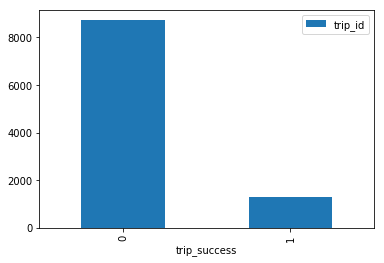

In [206]:
hist_trip = pd.DataFrame(df.groupby(['trip_success'])['trip_id'].agg('count'))
hist_trip.plot(kind = 'bar')
print('The ratio of successful trip is', round(df['trip_success'].sum() / df['trip_success'].count(),3))

## Proportion of nationalities

The ratio of French drivers is 0.887


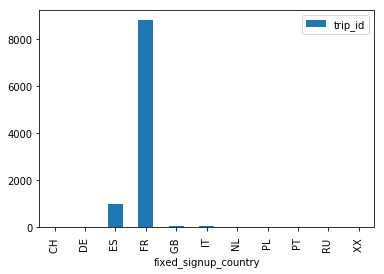

In [207]:
hist_nationalities = pd.DataFrame(df.groupby(['fixed_signup_country'])['trip_id'].agg('count'))
print('The ratio of French drivers is' , round(hist_nationalities.loc['FR ', :].values[0] / hist_nationalities.sum()[0], 3))
hist_nationalities.plot(kind = 'bar')

Most of users are French. I will not keep into account this feature for the machine learning model

## Visualize trips

I don't know how to use the 4 location features (from_lon, to_lon, from_lat, to_lat), so I decided to vizualize how the class 'success_trip' is distributed on a map.

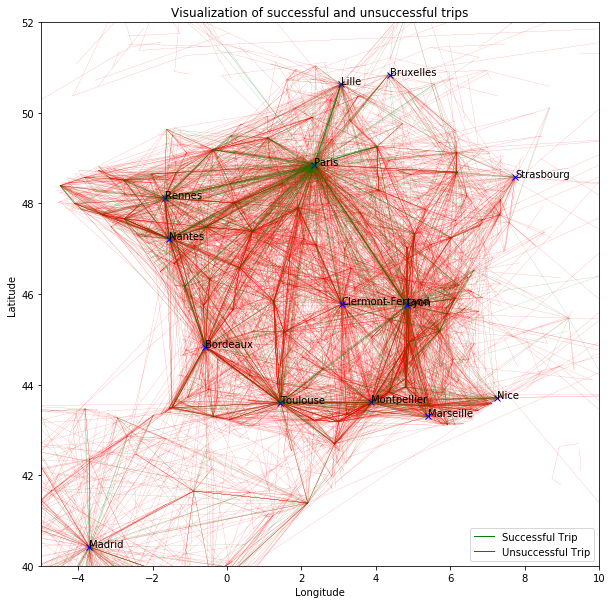

Time Execution : 116.711 s


In [208]:
t1 = time.clock()

df_success = df.loc[(df['trip_success'] == 1)]
df_nosuccess = df.loc[(df['trip_success'] == 0)]

# Plot trips
n_extract = n_sample

from_lon_nosuccess = np.array(df_nosuccess['from_lon'].iloc[:n_extract])
from_lat_nosuccess = np.array(df_nosuccess['from_lat'].iloc[:n_extract])
to_lon_nosuccess = np.array(df_nosuccess['to_lon'].iloc[:n_extract])
to_lat_nosuccess = np.array(df_nosuccess['to_lat'].iloc[:n_extract])

from_lon_success = np.array(df_success['from_lon'].iloc[:n_extract])
from_lat_success = np.array(df_success['from_lat'].iloc[:n_extract])
to_lon_success = np.array(df_success['to_lon'].iloc[:n_extract])
to_lat_success = np.array(df_success['to_lat'].iloc[:n_extract])

plt.figure(figsize=(10,10))
plt.xlim(-5, 10)
plt.ylim(40, 52)
    
for i in range (len(from_lon_nosuccess)):
    plt.plot((from_lon_nosuccess[i], to_lon_nosuccess[i]), (from_lat_nosuccess[i], to_lat_nosuccess[i]), 'r-', linewidth=0.1)
    
for i in range (len(from_lon_success)):
    plt.plot((from_lon_success[i], to_lon_success[i]), (from_lat_success[i], to_lat_success[i]), 'g-', linewidth=0.1)
    
# Plot some cities
cities = {'Paris' : {'longitude' : 2.3488, 'latitude' : 48.8534},
            'Marseille' : {'longitude' : 5.4, 'latitude' : 43.3},
            'Lyon' : {'longitude' : 4.85, 'latitude' :45.75},
            'Toulouse' : {'longitude' : 1.43, 'latitude' :43.6},
            'Nice' : {'longitude' : 7.25, 'latitude' :43.7},
            'Nantes' : {'longitude' : -1.5534, 'latitude' :47.2173},
            'Montpellier' : {'longitude' : 3.876, 'latitude' :43.61},
            'Strasbourg' : {'longitude' : 7.752, 'latitude' :48.573},
            'Bordeaux' : {'longitude' : -0.579, 'latitude' :44.838},
            'Lille' : {'longitude' : 3.07, 'latitude' :50.63},
            'Rennes' : {'longitude' : -1.677, 'latitude' :48.117},
            'Clermont-Ferrand' : {'longitude' : 3.087, 'latitude' :45.777},
            'Bruxelles' : {'longitude' : 4.389, 'latitude' :50.832},
            'Madrid' : {'longitude' : -3.703, 'latitude' :40.417}
         }

for city in cities:
    plt.plot(cities[city]['longitude'], cities[city]['latitude'], 'bx')
    plt.annotate(city, xy = (cities[city]['longitude'], cities[city]['latitude']))

#Try Clustering
'''
longitudes = pd.concat([df['from_lon'].iloc[:n_extract], df['to_lon'].iloc[:n_extract]])
latitudes = pd.concat([df['from_lat'].iloc[:n_extract], df['to_lat'].iloc[:n_extract]])
coordinates = pd.concat([longitudes, latitudes], axis = 1)
coordinates.columns = ['longitudes', 'latitudes']
KNN = KMeans(n_clusters = 40, algorithm = 'elkan')
KNN.fit(coordinates)
gravity_centers = KNN.cluster_centers_
X_gravity = gravity_centers[:, 0]
Y_gravity = gravity_centers[:, 1]
plt.plot(X_gravity, Y_gravity, 'ro')
'''

# Make Legend
custom_lines = [Line2D([0], [0], color='g', lw=1),
                Line2D([0], [0], color='r', lw=1)]
plt.legend(custom_lines, ['Successful Trip', 'Unsuccessful Trip'])
plt.title('Visualization of successful and unsuccessful trips')
plt.xlabel('Longitude')
plt.ylabel('Latitude')

plt.show()

t2 = time.clock()
print('Time Execution :', round(t2-t1,3), 's')

As I can expect, a lot of trip offers connects big cities. Most of successful trips are on these liaisons. 
Paris looks like a very big hub for drivers.

I have tried to build clusters but it was not satisfying.

These 4 location features will be dropped for the prediction models.

# III. Building prediction models

The objectif is to predict correctly if a trip is successful or not. Our evaluation measure will also be the Precision.

## Drop not useful columns

We don't keep columns related to order auto-incremented information, to location and to the class (confirmed_seat_count)

In [209]:
df = df[['is_main_trip', 
         'unit_seat_price_eur',
         'seat_offered_count', 
         'seat_left_count',
         'trip_distance_km',
         'is_comfort', 
         'is_auto_accept_mode',
         'order_delay', 
         'trip_day_of_week', 
         'driver_seniority',
         'trip_success']]

## Create train and test datasets

In [210]:
# Separate data and labels
X = df.iloc[:, :-1].values
Y = df.iloc[:, -1].values

# Create train and test datasets
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, random_state = 1)

## RandomForestClassifier

### Build Model and Train Data

In [211]:
t1 = time.clock()
clf = RandomForestClassifier(random_state=None)
clf.fit(X_train,Y_train)
Y_pred = clf.predict(X_test)
t2 = time.clock()

### See performances of the RandomForestClassifier

In [212]:
tn, fp, fn, tp = metrics.confusion_matrix(Y_test, Y_pred).ravel()
print('True Negative :', tn, '/ False Positive :', fp, '/ False Negative :', fn, '/ True Positive :', tp)
print('Confusion Matrix : \n', metrics.confusion_matrix(Y_test, Y_pred))
print('Precision :', round(metrics.accuracy_score(Y_test, Y_pred),3))
print('AUC :', round(metrics.roc_auc_score(Y_test, Y_pred),3))
print('Time Execution :', round(t2-t1,3), 's')

True Negative : 2103 / False Positive : 64 / False Negative : 248 / True Positive : 85
Confusion Matrix : 
 [[2103   64]
 [ 248   85]]
Precision : 0.875
AUC : 0.613
Time Execution : 0.206 s


Precision with RandomForest is quite good. Let's try do better.

I will select only most important variables in order to eliminate noise. Then, I will run RandomForest again, and try other models.

### See Variables Importances

                     importance  cumulative importance
trip_distance_km       0.179540               0.179540
order_delay            0.155216               0.334756
driver_seniority       0.152684               0.487440
seat_left_count        0.149099               0.636539
unit_seat_price_eur    0.128316               0.764855
seat_offered_count     0.080709               0.845564
is_main_trip           0.069064               0.914628
trip_day_of_week       0.066055               0.980683
is_auto_accept_mode    0.019317               1.000000
is_comfort             0.000000               1.000000
Index(['trip_distance_km', 'order_delay', 'driver_seniority',
       'seat_left_count', 'unit_seat_price_eur', 'seat_offered_count',
       'is_main_trip', 'trip_day_of_week', 'is_auto_accept_mode',
       'is_comfort'],
      dtype='object')


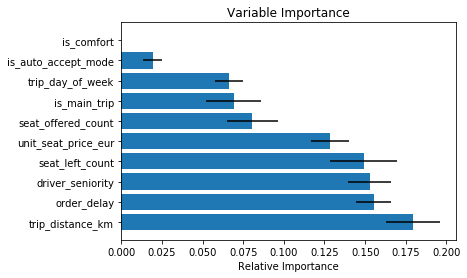

In [213]:
importances=clf.feature_importances_

features = df.columns[:-1]

feature_importances = pd.DataFrame(clf.feature_importances_, index = features, columns=['importance']).sort_values('importance',ascending=False)
feature_importances = pd.DataFrame(pd.concat([feature_importances,feature_importances.cumsum()], axis =1))
feature_importances.columns = ('importance', 'cumulative importance')
print(feature_importances)

std = np.std([tree.feature_importances_ for tree in clf.estimators_],axis=0)
sorted_idx = np.argsort(importances)[::-1]
print(features[sorted_idx])
padding = np.arange(X_train.size/len(X_train)) + 0.5
plt.barh(padding, importances[sorted_idx],xerr=std[sorted_idx], align='center')
plt.yticks(padding, features[sorted_idx])
plt.xlabel("Relative Importance")
plt.title("Variable Importance")
plt.show()

# IV. Optimize Precision with RandomForest

### Search best parameters

In [214]:
params = {
    'n_estimators': [10, 50, 100], 
    'criterion': ('gini', 'entropy')
}

clf = RandomForestClassifier(random_state=None)
clf = GridSearchCV(clf, params, scoring='precision', cv=5)
clf.fit(X_train, Y_train)

best_parameters = clf.best_params_
print('Best parameters:')
print(clf.best_params_)

Best parameters:
{'criterion': 'gini', 'n_estimators': 100}


### Keep 75% of information

In [215]:
df_reduced = df[['trip_distance_km', 
                 'driver_seniority', 
                 'order_delay',
                 'seat_left_count', 
                 'unit_seat_price_eur', 
                 'trip_success']]

### Train Data with the 5 most important variables and optimized parameters

In [216]:
X_reduced = df_reduced.values
Y = df_reduced.iloc[:, -1].values
X_train_reduced, X_test_reduced, Y_train, Y_test = train_test_split(X_reduced, Y, random_state = None)

In [217]:
t1 = time.clock()
clf = RandomForestClassifier(random_state=None, criterion = best_parameters['criterion'], n_estimators = best_parameters['n_estimators'])
clf.fit(X_train_reduced, Y_train)
Y_pred = clf.predict(X_test_reduced)
t2 = time.clock()
tn, fp, fn, tp = metrics.confusion_matrix(Y_test, Y_pred).ravel()
print('True Negative :', tn, '/ False Positive :', fp, '/ False Negative :', fn, '/ True Positive :', tp)
print('Confusion Matrix : \n', metrics.confusion_matrix(Y_test, Y_pred))
print('Precision :', round(metrics.accuracy_score(Y_test, Y_pred),3))
print('AUC :', round(metrics.roc_auc_score(Y_test, Y_pred),3))
print('Time Execution :', round(t2-t1,3), 's')

True Negative : 2181 / False Positive : 0 / False Negative : 0 / True Positive : 319
Confusion Matrix : 
 [[2181    0]
 [   0  319]]
Precision : 1.0
AUC : 1.0
Time Execution : 0.801 s


By selecting 5 most important features, Precision reachs 100%.

## Another Model : Naive Bayes

In [218]:
t1 = time.clock()
gnb = GaussianNB()
gnb.fit(X_train_reduced,Y_train)
Y_pred = gnb.predict(X_test_reduced)
t2 = time.clock()
tn, fp, fn, tp = metrics.confusion_matrix(Y_test, Y_pred).ravel()
print('True Negative :', tn, '/ False Positive :', fp, '/ False Negative :', fn, '/ True Positive :', tp)
print('Confusion Matrix : \n', metrics.confusion_matrix(Y_test, Y_pred))
print('Precision :', round(metrics.accuracy_score(Y_test, Y_pred),3))
print('AUC :', round(metrics.roc_auc_score(Y_test, Y_pred),3))
print('Time :', round(t2-t1,3), 's')

True Negative : 2181 / False Positive : 0 / False Negative : 0 / True Positive : 319
Confusion Matrix : 
 [[2181    0]
 [   0  319]]
Precision : 1.0
AUC : 1.0
Time : 0.016 s


Precision is still 100% with Naive Bayes.

## Another Model : DecisionTreeClassifier

In [219]:
t1 = time.clock()
tree = DecisionTreeClassifier()
tree.fit(X_train_reduced,Y_train)
Y_pred = tree.predict(X_test_reduced)
t2 = time.clock()
tn, fp, fn, tp = metrics.confusion_matrix(Y_test, Y_pred).ravel()
print('True Negative :', tn, '/ False Positive :', fp, '/ False Negative :', fn, '/ True Positive :', tp)
print('Confusion Matrix : \n', metrics.confusion_matrix(Y_test, Y_pred))
print('Precision :', round(metrics.accuracy_score(Y_test, Y_pred),3))
print('AUC :', round(metrics.roc_auc_score(Y_test, Y_pred),3))
print('Time Execution :', round(t2-t1,3), 's')

True Negative : 2181 / False Positive : 0 / False Negative : 0 / True Positive : 319
Confusion Matrix : 
 [[2181    0]
 [   0  319]]
Precision : 1.0
AUC : 1.0
Time Execution : 0.016 s


Precision is still 100% with a CART tree.

# Conclusion

This is a very interesting dataset. It has challenged me a lot, forced me to create new relevant features after cleaned some columns. Visualization of successful and unsuccessful trip was also exciting, even if I could not manage to include these location features into my prediction models.

After running a RandomForestClassifier, I have optimized its parameters and kept only  most relevant features.
The five most important features which preservers 75% of the information are: trip_distance_km, order_delay, driver_seniority, seat_left_count, unit_seat_price_eur

I have got 100% of prediction Precision. This seems a little bit weird that my solution performs so well. 
For a overall deployment using the 3 millions of rows, using a Naïve Bayes Classifier will be time-saving.